# Demo how to make predictions with OSnet, using all built-in default variables

|<img src="https://github.com/euroargodev/OSnet-GulfStream/raw/main/docs/_static/osnet_landscape.png" width="300px"/>|
|:---------:|
|``OSnet`` is a python library to make T/S/MLD predictions in the Gulf Stream Extension using Neural Network|

<b>Warning: These predictions are made using climatological input fields for SST and SLA !</b>

This notebook requires cartopy, cmocean and argopy

In [1]:
import os, sys
# Assume OSnet is one parent folder away from this notebook:
sys.path.insert(0, os.path.split(os.path.abspath(os.path.curdir))[0])  
import osnet
from osnet.options import OPTIONS
osnet.disclaimer()

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import argopy
import matplotlib.pyplot as plt
import math
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import colorcet as cc
import cmocean

from scipy.interpolate import griddata

# Dictionnary of colormaps for variables
cmapd = {'BATHY': cmocean.cm.topo, 
      'MDT': cmocean.cm.delta, 
      'SST': cmocean.cm.thermal, 
      'SLA': cmocean.cm.balance, 
      'UGOSA': cmocean.cm.balance, 
      'VGOSA': cmocean.cm.balance, 
      'UGOS': cmocean.cm.balance,
      'VGOS': cmocean.cm.balance,
      'temp': cmocean.cm.thermal, 
      'temp_adj': cmocean.cm.thermal, 
      'temp_std': cmocean.cm.amp, 
      'psal': cmocean.cm.haline, 
      'PSAL': cmocean.cm.haline,
      'psal_adj': cmocean.cm.haline, 
      'psal_std': cmocean.cm.amp, 
      'sig': cmocean.cm.dense, 
      'sig_adj': cmocean.cm.dense, 
      'sig_std': cmocean.cm.amp, 
      'mld': cc.cm["rainbow"]
     }


# Load OSnet model

In [3]:
%%time
m = osnet.load('Gulf-Stream')
m

/home/loick/miniconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


CPU times: user 7.25 s, sys: 245 ms, total: 7.5 s
Wall time: 7.55 s


<osnet.GulfStream>
Reference: Pauthenet et al, 2022 (http://dx.doi.org/...)
Models: 15 instance(s) in the ensemble
MLD adjusted: True

# Input

In [4]:
argo_loader = argopy.DataFetcher()
idx = argo_loader.region([-81.0,-29.5,22.0,50.5,0,1000, '2020-06-15', '2020-08-31']) 
ds = idx.to_xarray()
ds_true = ds.argo.point2profile()
ds_true

<xarray.Dataset>
Dimensions:                (N_PROF: 1200, N_LEVELS: 697)
Coordinates:
  * N_PROF                 (N_PROF) int64 1017 800 273 923 ... 451 232 63 996
  * N_LEVELS               (N_LEVELS) int64 0 1 2 3 4 5 ... 692 693 694 695 696
    LATITUDE               (N_PROF) float64 46.09 24.25 28.66 ... 36.18 46.77
    LONGITUDE              (N_PROF) float64 -32.53 -49.4 ... -51.53 -33.94
    TIME                   (N_PROF) datetime64[ns] 2020-06-15T00:47:00 ... 20...
Data variables: (12/13)
    CONFIG_MISSION_NUMBER  (N_PROF) int32 2 4 5 -1 6 4 2 6 ... 2 2 2 -1 4 5 2 2
    CYCLE_NUMBER           (N_PROF) int32 124 49 224 119 155 ... 155 238 145 152
    DATA_MODE              (N_PROF) <U1 'D' 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'D'
    DIRECTION              (N_PROF) <U1 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER        (N_PROF) int32 6902696 4903054 ... 3901603 6901754
    POSITION_QC            (N_PROF) int32 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    ...                     ...
    PRES_QC                (N_PROF) int32 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    PSAL                   (N_PROF, N_LEVELS) float32 35.81 35.81 ... nan nan
    PSAL_QC                (N_PROF) int32 1 1 1 1 1 2 1 1 1 ... 1 1 1 1 1 1 1 1
    TEMP                   (N_PROF, N_LEVELS) float32 14.78 14.78 ... nan nan
    TEMP_QC                (N_PROF) int32 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    TIME_QC                (N_PROF) int32 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://erddap.ifremer.fr/erddap
    Fetched_by:           loick
    Fetched_date:         2023/03/11
    Fetched_constraints:  [x=-81.00/-29.50; y=22.00/50.50; z=0.0/1000.0; t=20...
    Fetched_uri:          ['https://erddap.ifremer.fr/erddap/tabledap/ArgoFlo...
    history:              Variables filtered according to DATA_MODE; Variable...

# Prediction

In [5]:
ds_in_argo = ds_true[['LATITUDE','LONGITUDE','TIME']].rename({'N_PROF':'sampling','LATITUDE':'lat','LONGITUDE':'lon','TIME':'time'})
ds_in_argo

<xarray.Dataset>
Dimensions:   (sampling: 1200)
Coordinates:
    lat       (sampling) float64 46.09 24.25 28.66 27.94 ... 28.66 36.18 46.77
    lon       (sampling) float64 -32.53 -49.4 -52.79 ... -73.26 -51.53 -33.94
    time      (sampling) datetime64[ns] 2020-06-15T00:47:00 ... 2020-08-30T23...
  * sampling  (sampling) int64 1017 800 273 923 396 696 ... 888 451 232 63 996
Data variables:
    *empty*
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://erddap.ifremer.fr/erddap
    Fetched_by:           loick
    Fetched_date:         2023/03/11
    Fetched_constraints:  [x=-81.00/-29.50; y=22.00/50.50; z=0.0/1000.0; t=20...
    Fetched_uri:          ['https://erddap.ifremer.fr/erddap/tabledap/ArgoFlo...
    history:              Variables filtered according to DATA_MODE; Variable...

In [6]:
ds_out_argo = m.predict(ds_in_argo)
ds_out_argo

35/35 [==============================] - 0s 5ms/step


<xarray.Dataset>
Dimensions:            (sampling: 1200, PRES_INTERPOLATED: 51)
Coordinates:
  * sampling           (sampling) int64 1017 800 273 923 396 ... 451 232 63 996
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 0 1 2 3 4 ... 773 857 950 1000
    lat                (sampling) float64 46.09 24.25 28.66 ... 36.18 46.77
    lon                (sampling) float64 -32.53 -49.4 -52.79 ... -51.53 -33.94
    time               (sampling) datetime64[ns] 2020-06-15T00:47:00 ... 2020...
Data variables:
    temp_adj           (sampling, PRES_INTERPOLATED) float64 15.13 ... 4.669
    psal_std           (sampling, PRES_INTERPOLATED) float32 0.03448 ... 0.01112
    psal               (sampling, PRES_INTERPOLATED) float32 35.77 ... 34.97
    temp               (sampling, PRES_INTERPOLATED) float32 15.29 ... 4.669
    mld                (sampling) float64 26.0 26.0 16.0 19.0 ... 30.0 30.0 26.0
    sig                (sampling, PRES_INTERPOLATED) float64 26.5 26.5 ... 27.7
    sig_adj            (sampling, PRES_INTERPOLATED) float64 26.55 ... 27.7
    psal_adj           (sampling, PRES_INTERPOLATED) float64 35.78 ... 34.97
    temp_std           (sampling, PRES_INTERPOLATED) float32 0.151 ... 0.09367
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://erddap.ifremer.fr/erddap
    Fetched_by:           loick
    Fetched_date:         2023/03/11
    Fetched_constraints:  [x=-81.00/-29.50; y=22.00/50.50; z=0.0/1000.0; t=20...
    Fetched_uri:          ['https://erddap.ifremer.fr/erddap/tabledap/ArgoFlo...
    history:              Variables filtered according to DATA_MODE; Variable...
    OSnet-Nsample:        1119
    OSnet:                This dataset has variable(s) generated with an OSne...

In [8]:
ds_interp = ds_true.argo.interp_std_levels(ds_out_argo['PRES_INTERPOLATED'].values).rename({'N_PROF':'sampling'})
print(ds_interp)

<xarray.Dataset>
Dimensions:                (sampling: 256, PRES_INTERPOLATED: 51)
Coordinates:
  * sampling               (sampling) int64 800 704 515 523 ... 506 537 1158 451
    LATITUDE               (sampling) float64 24.25 36.76 31.31 ... 24.16 28.67
    LONGITUDE              (sampling) float64 -49.4 -59.73 ... -63.13 -59.34
    TIME                   (sampling) datetime64[ns] 2020-06-15T01:53:26 ... ...
  * PRES_INTERPOLATED      (PRES_INTERPOLATED) int64 0 1 2 3 ... 857 950 1000
Data variables:
    CONFIG_MISSION_NUMBER  (sampling) int32 4 6 1 1 1 5 7 11 ... 4 1 4 4 1 28 4
    CYCLE_NUMBER           (sampling) int32 49 93 115 115 104 ... 125 106 28 155
    DATA_MODE              (sampling) <U1 'D' 'D' 'D' 'D' ... 'D' 'A' 'A' 'D'
    DIRECTION              (sampling) <U1 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER        (sampling) int32 4903054 4902927 ... 6903720 4902339
    PRES                   (sampling, PRES_INTERPOLATED) float32 0.44 ... 1e+03
    PSAL      

In [10]:
#DS prédiction
print(ds_out_argo)

<xarray.Dataset>
Dimensions:            (sampling: 1200, PRES_INTERPOLATED: 51)
Coordinates:
  * sampling           (sampling) int64 1017 800 273 923 396 ... 451 232 63 996
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 0 1 2 3 4 ... 773 857 950 1000
    lat                (sampling) float64 46.09 24.25 28.66 ... 36.18 46.77
    lon                (sampling) float64 -32.53 -49.4 -52.79 ... -51.53 -33.94
    time               (sampling) datetime64[ns] 2020-06-15T00:47:00 ... 2020...
Data variables:
    temp_adj           (sampling, PRES_INTERPOLATED) float64 15.13 ... 4.669
    psal_std           (sampling, PRES_INTERPOLATED) float32 0.03448 ... 0.01112
    psal               (sampling, PRES_INTERPOLATED) float32 35.77 ... 34.97
    temp               (sampling, PRES_INTERPOLATED) float32 15.29 ... 4.669
    mld                (sampling) float64 26.0 26.0 16.0 19.0 ... 30.0 30.0 26.0
    sig                (sampling, PRES_INTERPOLATED) float64 26.5 26.5 ... 27.7
    sig_adj          

In [11]:
#DS réel
print(ds_interp)

<xarray.Dataset>
Dimensions:                (sampling: 256, PRES_INTERPOLATED: 51)
Coordinates:
  * sampling               (sampling) int64 800 704 515 523 ... 506 537 1158 451
    LATITUDE               (sampling) float64 24.25 36.76 31.31 ... 24.16 28.67
    LONGITUDE              (sampling) float64 -49.4 -59.73 ... -63.13 -59.34
    TIME                   (sampling) datetime64[ns] 2020-06-15T01:53:26 ... ...
  * PRES_INTERPOLATED      (PRES_INTERPOLATED) int64 0 1 2 3 ... 857 950 1000
Data variables:
    CONFIG_MISSION_NUMBER  (sampling) int32 4 6 1 1 1 5 7 11 ... 4 1 4 4 1 28 4
    CYCLE_NUMBER           (sampling) int32 49 93 115 115 104 ... 125 106 28 155
    DATA_MODE              (sampling) <U1 'D' 'D' 'D' 'D' ... 'D' 'A' 'A' 'D'
    DIRECTION              (sampling) <U1 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER        (sampling) int32 4903054 4902927 ... 6903720 4902339
    PRES                   (sampling, PRES_INTERPOLATED) float32 0.44 ... 1e+03
    PSAL      

In [12]:
#Calcul erreur

#Min Max
temp_data = [i for i in ds_interp['TEMP'].data.flatten()]
max_temp_data = max(temp_data) 
min_temp_data = min(temp_data)

ds_interp = ds_interp.assign(relative_error=ds_interp.TEMP)


for i in range(len(ds_interp['sampling'])):
    for j in range(len(ds_interp['PRES_INTERPOLATED'])):
        ds_interp['relative_error'][i][j] = (abs(ds_interp['TEMP'][i][j] - ds_out_argo['temp'][i][j])) / (max_temp_data - min_temp_data)
                      

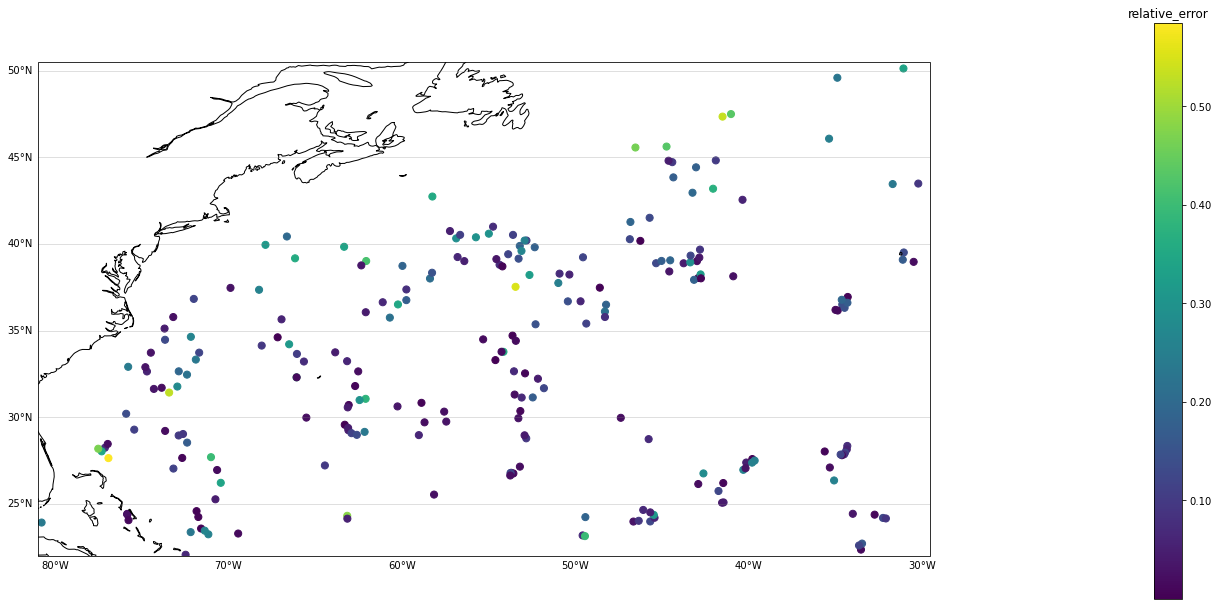

In [15]:
import matplotlib.ticker as ticker


# Create a figure object and add an axis with PlateCarree projection
fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add land and ocean features to the map
ax.coastlines()

#Display grid
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5)
    
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
#Display lat long in margin
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Plot the data on the map
scatter = ax.scatter(ds_interp['LONGITUDE'], ds_interp['LATITUDE'], s=50, 
                     c=ds_interp['relative_error'].sel(PRES_INTERPOLATED=400, method='nearest'), 
                     transform=ccrs.PlateCarree())
ax.set_extent([-81.0,-29.5,22.0,50.5], crs=ccrs.PlateCarree())

# Add colorbar
cbar = plt.colorbar(scatter, format=ticker.FuncFormatter(lambda x, pos: f'{x:.2f}'))

# Set title for colorbar
cbar.ax.set_title('relative_error')

# Move colorbar to the right and outside of the map
cbar.ax.yaxis.set_label_position('right')
cbar.ax.set_position([0.9, 0.1, 0.03, 0.8])

# Show the map
plt.show()